# TensorFlow Tutorials
### A boring work-through of the tutorials
David Norrish, 2/10/2017  

Working through of the TensorFlow tutorials, with a couple of extra MatPlotLib visualisations added. Best just for beginner reference (possibly just my own).

Assumes you already have TensorFlow and (obviously) Jupyter Notebook installed  

## 1. Getting started with TensorFlow

Tutorial from https://www.tensorflow.org/get_started/mnist/beginners

Firstly, import the package to give Python access to all of TensorFlow's classes, methods, and symbols

In [1]:
import tensorflow as tf

A **tensor** is a set of primitive values shaped into an array of any number of dimensions. A tensor's rank is its number of dimensions. E.g.

- 3 
  - a rank 0 tensor; this is a scalar with shape []
- [1., 2., 3.] 
  - a rank 1 tensor; this is a vector with shape [3]
- [[1., 2., 3.], [4., 5., 6.]] 
  - a rank 2 tensor; a matrix with shape [2, 3]
- [[[1., 2., 3.]], [[7., 8., 9.]]]
  - a rank 3 tensor with shape [2, 1, 3]


A 'computational graph' is a series of TensorFlow operations arranged into a graph of nodes. Each node takes one or more tensor as inputs and produces a tensor as an output. A node can be a constant, which takes no inputs and stores its output value internally.  

TensorFlow's Core programs essentially consist of two discrete sections:

- Building the computational graph
- Running the computational graph  

Let's build a simple computational graph.

Let's create 2 floating point tensors to start with

In [2]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1, node2)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


Note that these constants are nodes that, when evaluated, would produce 3.0 and 4.0.  
TF relies on a highly efficient C++ backend to do its computation. The connection to this backend is called a **session**.  
  
TF evaluates nodes by run the computational graph within a session, which encapsulates the control and state of the TensorFlow runtime.

In [3]:
sess = tf.Session()
print(sess.run([node1, node2]))

[3.0, 4.0]


Can build more complicated computations by combining Tensor nodes with operations (Operations are also nodes)

In [4]:
node3 = tf.add(node1, node2)
print("node3:", node3)
print("sess.run(node3):", sess.run(node3))

node3: Tensor("Add:0", shape=(), dtype=float32)
sess.run(node3): 7.0


We only have constants at the moment, which is boring. A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later. Let's use these for now.

In [5]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
adder_node = a + b  # + provides a shortcut for tf.add(a, b)


In [6]:
print(sess.run(adder_node, {a: 3, b: 4.5}))
print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))

7.5
[ 3.  7.]


We can make this more complex by adding another operation

In [7]:
add_and_triple = adder_node * 3.
print(sess.run(add_and_triple, {a: 3, b: 4.5}))

22.5


Variables allow us to add **trainable parameters** to a graph.  

W is the weights of the model, and b is the biases.

In [8]:
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
x = tf.placeholder(tf.float32)
linear_model = W * x + b

Unlike constants, to initialize all the variables in a TensorFlow program, you must explicitly call a special operation, `init`. This is a handle to the TensorFlow sub-graph that initializes all the global variables. Until we call `sess.run()`, the variables are uninitialized

In [9]:
init = tf.global_variables_initializer()
sess.run(init)

`x` is a placeholder, so can evaluate `linear_model` for several values of x simultaneously

In [10]:
print(sess.run(linear_model, {x: [1, 2, 3, 4]}))

[ 0.          0.30000001  0.60000002  0.90000004]


We've created a model, but we don't know how good it is yet. To evaluate the model on training data, we need a y placeholder to provide the desired values, and we need to write a *loss* function.  
This measures how far apart the current model is from the provided data. We'll use a standard loss model for linear regression, which sums the squares of the deltas between the current model and the provided data.  
  
`(linear_model - y)` creates a vector where each element is the corresponding example's error delta. We call `tf.square` to square that error. Then, we sum all the squared errors to create a single scalar that abstracts the error of all examples using `tf.reduce_sum`

In [11]:
y = tf.placeholder(tf.float32)
squared_deltas = tf.square(linear_model - y)
loss = tf.reduce_sum(squared_deltas)
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

23.66


Our random choices of W and b clearly weren't perfect. We can re-assign them to their optimal values of -1 and 1 respectively.

In [12]:
fixW = tf.assign(W, [-1.])
fixb = tf.assign(b, [1.])
# I guess similar to running global_variables_initializer()
sess.run([fixW, fixb])
print(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))

0.0


Yay, our loss is now 0. That's great, but this is machine learning! We want to **find** the parameter values. TensorFlow provides optimizers that slowly change each variable in order to minimize the loss function. The simplest optimizer is gradient descent.  
  
*Gradient descent modifies each variable according to the magnitude of the derivative of loss with respect to that variable*

In [13]:
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)
# Recall that 'loss' is the sum of squared error function
sess.run(init) # reset values to incorrect defaults.
W_vals, b_vals, loss_vals = [], [], []
for i in range(1000):
    sess.run(train, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]})
    # keep track of value changes as we go to graph in next step
    W_vals.append(sess.run(W))
    b_vals.append(sess.run(b))
    loss_vals.append(sess.run(loss, {x: [1, 2, 3, 4], y: [0, -1, -2, -3]}))
    if i % 100 == 0:
        print(sess.run([W, b]))

print(sess.run([W, b]))

[array([-0.21999997], dtype=float32), array([-0.456], dtype=float32)]
[array([-0.84270465], dtype=float32), array([ 0.53753263], dtype=float32)]
[array([-0.95284992], dtype=float32), array([ 0.86137295], dtype=float32)]
[array([-0.98586655], dtype=float32), array([ 0.95844597], dtype=float32)]
[array([-0.99576342], dtype=float32), array([ 0.98754394], dtype=float32)]
[array([-0.99873012], dtype=float32), array([ 0.99626648], dtype=float32)]
[array([-0.99961936], dtype=float32), array([ 0.99888098], dtype=float32)]
[array([-0.99988592], dtype=float32), array([ 0.9996646], dtype=float32)]
[array([-0.99996579], dtype=float32), array([ 0.99989945], dtype=float32)]
[array([-0.99998969], dtype=float32), array([ 0.99996972], dtype=float32)]
[array([-0.9999969], dtype=float32), array([ 0.99999082], dtype=float32)]


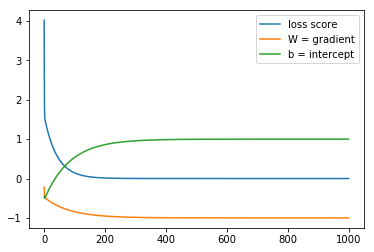

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_vals)
plt.plot(W_vals)
plt.plot(b_vals)
plt.legend(['loss score', 'W = gradient', 'b = intercept'], loc='upper right')
plt.show()

As we can see, with a learning rate of 0.01 for the gradient descent optimizer, it takes about 200 generations for the loss score to asymptote to be very close to 0, and about an extra 200 generations for W and b to converge on essentially their final values.

The complete trainable linear model, in all its stand-alone glory!

In [15]:
import tensorflow as tf

# Model parameters
W = tf.Variable([.3], dtype=tf.float32)
b = tf.Variable([-.3], dtype=tf.float32)
# Model input and output
x = tf.placeholder(tf.float32)
linear_model = W * x + b
y = tf.placeholder(tf.float32)

# loss
loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# training data
x_train = [1, 2, 3, 4]
y_train = [0, -1, -2, -3]
# training loop
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) # set values to wrong
for i in range(1000):
    sess.run(train, {x: x_train, y: y_train})

# evaluate training accuracy
curr_W, curr_b, curr_loss = sess.run([W, b, loss], {x: x_train, y: y_train})
print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))

W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


### tf.estimator
tf.estimator is a high-level TensorFlow library that simplifies the mechanics of machine learning, including the following:

- running training loops
- running evaluation loops
- managing data sets

Basic usage for the previous problem:

In [16]:
import tensorflow as tf
# NumPy is often used to load, manipulate and preprocess data.
import numpy as np

# Declare list of features. We only have one numeric feature. There are many
# other types of columns that are more complicated and useful.
feature_columns = [tf.feature_column.numeric_column("x", shape=[1])]

# An estimator is the front end to invoke training (fitting) and evaluation
# (inference). There are many predefined types like linear regression,
# linear classification, and many neural network classifiers and regressors.
# The following code provides an estimator that does linear regression.
estimator = tf.estimator.LinearRegressor(feature_columns=feature_columns)

# TensorFlow provides many helper methods to read and set up data sets.
# Here we use two data sets: one for training and one for evaluation
# We have to tell the function how many batches
# of data (num_epochs) we want and how big each batch should be.
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

# We can invoke 1000 training steps by invoking the method and passing the
# training data set.
estimator.train(input_fn=input_fn, steps=1000)

# Here we evaluate how well our model did.
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print("train metrics: %r"% train_metrics)
print("eval metrics: %r"% eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmpjbzggxy7', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\User\AppData\Local\Temp\tmpjbzggxy7\model.ckpt.
INFO:tensorflow:loss = 14.0, step = 1
INFO:tensorflow:global_step/sec: 800.096
INFO:tensorflow:loss = 0.439799, step = 101 (0.125 sec)
INFO:tensorflow:global_step/sec: 914.248
INFO:tensorflow:loss = 0.115915, step = 201 (0.109 sec)
INFO:tensorflow:global_step/sec: 1066.6
INFO:tensorflow:loss = 0.0136125, step = 301 (0.094 sec)
INFO:tensorflow:global_step/sec: 1010.54
INFO:tensorflow:loss = 0.000627999, step = 401 (0.099 sec)
INFO:tensorflow:global_step/sec: 914.234
INFO:tens

### A custom `estimator` model
We can still retain the high level abstraction of data set, feeding, training, etc. of `tf.estimator`, while creating a custom model that is not built into TensorFlow.  
  
`tf.estimator.LinearRegressor` is actually a sub-class of `tf.estimator.Estimator`. Instead of sub-classing `Estimator`, we simply provide `Estimator` a function `model_fn`

In [17]:
import numpy as np
import tensorflow as tf

# Declare list of features, we only have one real-valued feature, 'labels'
def model_fn(features, labels, mode):
    # Build a linear model and predict values
    W = tf.get_variable("W", [1], dtype=tf.float64)
    b = tf.get_variable("b", [1], dtype=tf.float64)
    y = W * features['x'] + b
    # Loss sub-graph
    loss = tf.reduce_sum(tf.square(y - labels))
    # Training sub-graph
    global_step = tf.train.get_global_step()
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = tf.group(optimizer.minimize(loss),
                   tf.assign_add(global_step, 1))
    # EstimatorSpec connects subgraphs we built to the
    # appropriate functionality.
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=y,
        loss=loss,
        train_op=train)

estimator = tf.estimator.Estimator(model_fn=model_fn)
# define our data sets
x_train = np.array([1., 2., 3., 4.])
y_train = np.array([0., -1., -2., -3.])
x_eval = np.array([2., 5., 8., 1.])
y_eval = np.array([-1.01, -4.1, -7, 0.])
input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=None, shuffle=True)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=4, num_epochs=1000, shuffle=False)
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    {"x": x_eval}, y_eval, batch_size=4, num_epochs=1000, shuffle=False)

# train
estimator.train(input_fn=input_fn, steps=1000)
# Here we evaluate how well our model did.
train_metrics = estimator.evaluate(input_fn=train_input_fn)
eval_metrics = estimator.evaluate(input_fn=eval_input_fn)
print("train metrics: %r"% train_metrics)
print("eval metrics: %r"% eval_metrics)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmpogkf5nj1', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\User\AppData\Local\Temp\tmpogkf5nj1\model.ckpt.
INFO:tensorflow:loss = 3.15136617367, step = 1
INFO:tensorflow:global_step/sec: 914.26
INFO:tensorflow:loss = 0.0118320647215, step = 101 (0.109 sec)
INFO:tensorflow:global_step/sec: 1279.95
INFO:tensorflow:loss = 0.0019633222891, step = 201 (0.078 sec)
INFO:tensorflow:global_step/sec: 914.234
INFO:tensorflow:loss = 0.000359623509284, step = 301 (0.109 sec)
INFO:tensorflow:global_step/sec: 1066.61
INFO:tensorflow:loss = 6.64644507019e-05, step = 401 (0.094 sec)
INFO:tensorfl

## 2. MNIST for ML beginners
Tutorial available at https://www.tensorflow.org/get_started/mnist/beginners

The Modified National Institute of Standards and Technology database (MNIST) is a large database of handwritten digits that is commonly used for training various image processing systems. It is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). Analysing it is the ML equivalent of Hello World.  
  
MNIST is split into three parts:
- 55,000 data points of training data (mnist.train)
- 10,000 points of test data (mnist.test)
- 5,000 points of validation data (mnist.validation)
  
Each image is 28 pixels by 28 pixels. We can flatten this into a vector of 28x28 = 784 floats, each from [0, 1].
  
Flattening the data throws away information about the 2D structure of the image. This is kind of bad, but we'll start with a very simple model called a SoftMax regression, which doesn't use this structure anyway.  
  
The result is mnist.train.images will be a tensor (an n-dimensional array) with a shape of [55000, 784].  
We're going to want our labels as "one-hot vectors", a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the n<sup>th</sup> digit will be represented as a vector which is 1 in the n<sup>th</sup> dimension (e.g. 3 would be [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [18]:
# Read in this sweet, sweet data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Softmax

If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives us a list of values between 0 and 1 that add up to 1. Even later on, when we train more sophisticated models, the final step will be a layer of softmax.

It has two steps:
1. add up the evidence of our input being in certain classes
2. convert that evidence into probabilities
  
To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel 
intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.

We also add some extra evidence called a bias. Basically, we want to be able to say that some things are more likely independent of the input. The result is that the evidence for a class *i* given an input *x* is:

evidence<sub>i</sub> = &Sigma;<sub>j</sub> (W<sub>i, j</sub> x<sub>j</sub> + b<sub>i</sub>)  
  
Where W<sub>i</sub> is the weights and b<sub>i</sub> is the bias for class *i* and *j* is an index for summing over our input image *x*  
  
We then convert the evidence tallies into our predicted probabilities *y* using the "softmax" function:  

y = softmax(evidence)  
  
Here softmax is serving as an "activation" or "link" function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. I.e. it converts tallies of evidence into probabilities of our input being in each class. Definition:  
  
softmax(x)<sub>i</sub> = exp(x<sub>i</sub>) / &Sigma;<sub>j</sub> exp(x<sub>j</sub>)  
  
Softmax exponentiates its inputs and then normalizes them. The exponentiation means that one more unit of evidence increases the weight given to any hypothesis multiplicatively. And conversely, having one less unit of evidence means that a hypothesis gets a fraction of its earlier weight. No hypothesis ever has zero or negative weight.  
  
Essentially we'll be doing:  
y = softmax(W<sub>x</sub> + b)  
  
Well, I'm thosoughly confused. Time to get started!

### Implementing the regression
TensorFlow does its heavy lifting outside Python using highly efficient code implemented in another language, but it's still to switch back to Python after every operation. To avoid this, TensorFlow lets us describe a graph of interacting operations that run entirely outside Python.

In [19]:
import tensorflow as tf
# Allow inputting any number of MNIST images, each flattened into a 784-dimensional vector
# 'None' means a dimension can be of any length
x = tf.placeholder(tf.float32, [None, 784])

A Variable is a modifiable tensor that lives in TensorFlow's graph of interacting operations. It can be used and even modified by the computation. For machine learning applications, one generally has the model parameters be Variables

In [20]:
# initialise both variables as 0s. We are going to learn them so doesn't matter what they start as
# 784-dimensional image vectors by 10-dimensional vectors of evidence for the difference classes
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

We can now implement the model in a single line!  
Multiply x by W with the expression `tf.matmul(x, W)`  
This is flipped from when we multiplied them in our equation, where we had W<sub>x</sub>, as a small trick to deal with x being a 2D tensor with multiple inputs.  
  
Then add b (and call softmax, unless using the more stable version commented out below).

In [21]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

### Training
We'll use "cross entropy" to determine our loss function. It arises from thinking about information compressing codes in information theory and is useful everywhere.  
  
H<sub>y'</sub> = -&Sigma;<sub>i</sub> y'<sub>i</sub> log(y<sub>i</sub>)  
  
Where y is our predicted probability distribution, and y' is the true distribution (the one-hot vector with the digit labels).  
  
To implement cross-entropy we need to first add a new placeholder to input the correct answers, then implement the cross-entropy function.  
  
First, `tf.log` computes the logarithm of each element of y. Next, we multiply each element of y_ with the corresponding element of `tf.log(y)`. Then `tf.reduce_sum` adds the elements in the second dimension of y, due to the `reduction_indices=[1]` parameter. Finally, `tf.reduce_mean` computes the mean over all the examples in the batch.

In [22]:
y_ = tf.placeholder(tf.float32, [None, 10])
# not numerically stable, but functionally what's happening, and carried out properly by tf.nn function below:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# cross_entropy = tf.reduce_mean(
#    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Now that we know what we want our model to do, it's very easy to have TensorFlow train it to do so. Because TensorFlow knows the entire graph of your computations, it can automatically use the backpropagation algorithm to efficiently determine how your variables affect the loss you ask it to minimize. Then it can apply your choice of optimization algorithm to modify the variables and reduce the loss.  
  
Note that an **InteractiveSession** makes TensorFlow more flexible about how you structure your code. It allows you to interleave operations which build a computation graph with ones that run the graph.

In [23]:
# Learning rate of 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
# launch the model in an interactive session
sess = tf.InteractiveSession()
# Initialise the variables created
tf.global_variables_initializer().run()

Each step of the loop, we'll get a "batch" of one hundred random data points from our training set. We run `train_step` feeding in the batches data to replace the placeholders.  
  
Using small batches of random data is called stochastic training -- in this case, stochastic gradient descent. Ideally, we'd like to use all our data for every step of training because that would give us a better sense of what we should be doing, but that's expensive. So, instead, we use a different subset every time. Doing this is cheap and has much of the same benefit.

In [24]:
# time to train - let's run 1000 times
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

### Evaluating the model
First figure out where we predicted the correct label. `tf.argmax` is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, `tf.argmax(y,1)` is the label our model thinks is most likely for each input, while `tf.argmax(y_,1)` is the correct label. We can use `tf.equal` to check if our prediction matches the truth

In [25]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75

In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9151


And that's our overall accuracy - 92%. This isn't bad, certainly not great (the best get up around 99.7% accuracy). We'll get closer to that score in the next sections.

## 3. Deep MNIST for experts
Tutorial at: https://www.tensorflow.org/get_started/mnist/pros

Here we construct a deep convolutional neural network for MNIST classification, and improve on the performance of the simpler model just implemented.  

The tasks covered are:

- Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image
- Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples (and run our first Tensorflow session to do so)
- Check the model's accuracy with our test data
- Build, train, and test a multilayer convolutional neural network to improve the results  

`mnist` is a lightweight class which stores the training, validation, and testing sets as NumPy arrays. It also provides a function for iterating through data minibatches, which we will use below

In [27]:
# Read in the MNIST data again
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [28]:
# Import TF and initialise an InteractiveSession, which lets you interleave
# building the computation graph with ones that run the graph
import tensorflow as tf
sess = tf.InteractiveSession()

First we build a softmax regression model again with a single linear layer, then extend this to a softmax with multilayer convolutional network.  
  
The input images x will consist of a 2d tensor of floating point numbers. Here we assign it a shape of [None, 784], where 784 is the dimensionality of a single flattened 28 by 28 pixel MNIST image, and None indicates that the first dimension, corresponding to the batch size, can be of any size. The target output classes y_ will also consist of a 2d tensor, where each row is a one-hot 10-dimensional vector indicating which digit class (zero through nine) the corresponding MNIST image belongs to.  

Create nodes for the input images and target output classes

In [29]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Now define the weight W and bias b of the model.  

A Variable is a value that lives in TensorFlow's computation graph. It can be used and even modified by the computation. In machine learning applications, one generally has the model parameters be Variables.  

Remember, **W** is the weights, and **b** is the biases. Initialises them as 0s, as they shall be learned

In [30]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())

Now we implement out regression model. Multiply the vectorized input images x by the weight matrix W and add the bias b

In [31]:
y = tf.matmul(x, W) + b

Now specify a loss function. Use the stable formulation to compute cross-entropy.  

`tf.nn.softmax_cross_entropy_with_logits` internally applies the softmax on the model's unnormalized model prediction and sums across all classes, and tf.reduce_mean takes the average over these sums

In [32]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Now use automatic differentiation to find the gradients of the loss with respect to each of the variables. Step length of 0.5. This specifically adds new operations to the computation graph, which compute gradients, compute parameter update steps, and apply update steps to the parameters

In [33]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Now to train the model.  

Load 100 training examples in each iteration. Note you can replace any tensor in the computing graph with `feed_dict`.

In [34]:
for _ in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})

Evaluate the model.  

`tf.argmax` gives you the index of the highest entry in a tensor along some axis. E.g. `tf.argmax(y,1)` is the label our model thinks is most likely for each input. `tf.argmax(y_,1)` is the true label

In [35]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

Gives a list of booleans. Cast it to floating point numbers then take the mean.

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9176


As before, get a result of ~92% accuracy.

## Build a multilayer convolutional network
92% is a bad result. We will build a network that passes through the following layers to boost that performance substantially:
1. reshape (weight initialization)
2. convolutional 1
3. pooling 1
4. convolutional 2
5. pooling 2
6. fully-connected 1
7. dropout
8. fully-connected 2
9. loss -> accuracy

### 1. Weight initialization
Good to generally initialize weights with a small amount of noise for symmetry breaking and to prevent 0 gradients. We're using 'rectified linear unit' (ReLU) neurons.  

These neurons are biological inspired, mathematically justified, and are more effective in convolutional networks alternatives such as the logistic sigmoid or hyperbolic tangent. As of 2015 it is [the most popular activation function for deep neural networks](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).  

Because ReLU neurons have 0 activation if their input is <= 0, they should be initialized with random positive weights.  

Define two functions that can be used repeatedly while building the model to generate starting weights

In [37]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### 2. Convolution and pooling
TensorFlow gives a lot of flexibility in convolution and pooling operations. Can set:  
- How to handle the boundaries
- Stride size

Here we'll stick to the vanilla version. Use a stride of one and zero-pad so that the output is the same size as the input. Pooling is plain old max pooling over 2x2 blocks. To keep the code cleaner, also abstract those operations into functions.

In [38]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

**First convolutional layer**  

This will consist of convolution followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [39]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [40]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

Then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to 14x14.

In [41]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

**Second convolutional layer**  

The second layer will have 64 features for each 5x5 patch.

In [42]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### 3. Densely connected layer
Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [43]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### 4. Dropout
To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's `tf.nn.dropout` op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [44]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### 5. Readout layer
Finally add a layer, just like for the one layer softmax regression above.

In [45]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## Trial and error evaluation
To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.  

The differences are:  

- Replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.
- Include the additional parameter keep_prob in feed_dict to control the dropout rate.  

Also use `tf.Session` rather than `tf.InteractiveSession`. This better separates the process of creating the graph (model specification) and the process of evaluating the graph (model fitting). It generally makes for cleaner code. The `tf.Session` is created within a `with` block so that it is automatically destroyed once the block is exited.  

NOTE: running this code with 10,000 iterations may take quite some time depending on your processor.

In [ ]:
# Softmax layer, as described in detail in the previous 2 sections
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

accuracy_evolution = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1], keep_prob: 1.0})
            accuracy_evolution.append(train_accuracy)         # store to plot afterwards
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.18
step 100, training accuracy 0.78
step 200, training accuracy 0.88
step 300, training accuracy 0.94
step 400, training accuracy 0.96
step 500, training accuracy 0.98
step 600, training accuracy 0.94
step 700, training accuracy 0.92
step 800, training accuracy 0.94
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
step 1100, training accuracy 0.98
step 1200, training accuracy 0.94
step 1300, training accuracy 0.92
step 1400, training accuracy 0.98
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.94
step 1900, training accuracy 0.94
step 2000, training accuracy 0.98
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 0.96
step 2400, training accuracy 1
step 2500, training accuracy 0.98
step 2600, training accuracy 0.96
step 2700, training accuracy 0.94
step 2800, training accuracy 0.98
step 2900, training accuracy 0.96
s

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accuracy_evolution)
plt.legend(['loss score'], loc='lower right')
plt.show()